# Image Subtraction with DC2

This notebook explores image subtraction techniques using DC2 data. 

#### Setup:

1. The following code is designed to be run at NERSC using the **`desc-stack`** kernel. 
2. You will need to set the **`site_pckgs_path`** variable to your user specific **`site-packages`** directory. This directory should be **`USER_DIR/.local/lib/python3.6/site-packages`** where **`USER_DIR`** can be found by opening a new terminal window (at NERSC) and typing the **`pwd`** command. 

In [1]:
site_pckgs_path = '/global/u1/d/djp81/.local/lib/python3.6/site-packages'

In [2]:
import os
import sys
from random import random

sys.path.insert(0, site_pckgs_path)

import numpy as np
import pandas as pd
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt

import GCRCatalogs
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
from desc_dc2_dm_data import REPOS

# Used for plotting
zscale = ZScaleInterval()


## Load Catalog Data

We note some of the available catalogs and load a few into the global name space. For more information on available catalogs, and for what catalog versions correspond to different runs, see the [DC2 Data Product Overview](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview).

In [3]:
all_catalogs = list(GCRCatalogs.available_catalogs.keys())

print('Cosmo DC2 catalogs:')
for c in all_catalogs:
    if 'cosmo' in c:
        print(f'    {c}')
        
print('\nProto DC2 catalogs:')
for c in all_catalogs:
    if 'proto' in c:
        print(f'    {c}')

print('\nTruth and Variable Catalogs:')
for c in all_catalogs:
    if 'truth' in c or 'variable' in c:
        print(f'    {c}')


Cosmo DC2 catalogs:
    cosmoDC2_v0.1
    cosmoDC2_v0.1_test
    cosmoDC2_v1.0
    cosmoDC2_v1.0_10194_10452
    cosmoDC2_v1.0_8786_9049
    cosmoDC2_v1.0_9050_9430
    cosmoDC2_v1.0_9431_9812
    cosmoDC2_v1.0_9556
    cosmoDC2_v1.0_9813_10193
    cosmoDC2_v1.0_image
    cosmoDC2_v1.0_image_addon_knots
    cosmoDC2_v1.0_small
    cosmoDC2_v1.1.3_small
    cosmoDC2_v1.1.4_image
    cosmoDC2_v1.1.4_image_addon_knots
    cosmoDC2_v1.1.4_image_photoz_calib
    cosmoDC2_v1.1.4_redmapper_v0.2.1py
    cosmoDC2_v1.1.4_small
    cosmoDC2_v1.1.4_small_photoz_calib
    pz_calibrate_references_cosmoDC2_v1.1.4_image
    pz_calibrate_references_cosmoDC2_v1.1.4_small

Proto DC2 catalogs:
    proto-dc2_v2.0
    proto-dc2_v2.0_redmapper
    proto-dc2_v2.0_test
    proto-dc2_v2.1.1
    proto-dc2_v2.1.2
    proto-dc2_v2.1.2_addon_knots
    proto-dc2_v2.1.2_addon_tidal
    proto-dc2_v2.1.2_test
    proto-dc2_v2.1
    proto-dc2_v3.0
    proto-dc2_v3.0_addon_knots
    proto-dc2_v3.0_addon_redmapper
    pro

We will consider data from Run 1.2i, which corresponds to Proto DC2 version 3.0 and Truth Catalogs version 1.2.

In [4]:
run = '1.2i'
repo = REPOS[run]
butler = dafPersist.Butler(repo)

# Cosmo DC2 contains host galaxy properties
dc2 = GCRCatalogs.load_catalog('proto-dc2_v3.0')

# Truth Variable Summary catalog specifies variable type and ids of variables and hosts
truth_variable_summary = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')

# Truth Variable Light Curve catalog contains the "observed" light curves
truth_variable_lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')

# Truth Variable Static catalog contains target meta data (ra, dec, redshift, etc.)
truth_variable_static = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')


Next we retreive meta data about the variable targets, including the host galaxy RA and Dec.

In [5]:
def get_variable_target_data(summary_ctlg, static_ctlg):
    """Return a dataframe with variable targets in DC2 that have matched hosts
    
    Args:
        summary_ctlg (Catalog): GCR DC2 Truth Variable Summary Catalog 
        static_ctlg  (Catalog): GCR DC2 Truth Variable Static Catalog 
        
    Returns:
        A DataFrame with meta data for variable targets
    """

    # Get variable targets with associated host galaxies
    summary_dict = truth_variable_summary.get_quantities(
        filters=['galaxy_id != -1'],
        quantities=[
            'uniqueId',
            'galaxy_id', 
            'redshift',
            'ra', 
            'dec', 
            'sn', 
            'agn']
    )

    summary_data = pd.DataFrame(summary_dict)
    summary_data.set_index('uniqueId', inplace=True)

    # Format galaxy ids to fix issue where ids do not match between catalogs
    # See https://github.com/LSSTDESC/gcr-catalogs/issues/272
    summary_data['galaxy_id'] = summary_data['galaxy_id'] % 1024

    # Get host galay information
    host_dict = truth_variable_static.get_quantities(['ra', 'dec', 'object_id', 'redshift'])
    host_dict['host_ra'] = host_dict.pop('ra')
    host_dict['host_dec'] = host_dict.pop('dec')
    host_dict['galaxy_id'] = host_dict.pop('object_id')
    host_dict['galaxy_redshift'] = host_dict.pop('redshift')
    host_data = pd.DataFrame(host_dict)

    return pd.merge(summary_data, host_data, on='galaxy_id')


In [6]:
target_data = get_variable_target_data(truth_variable_summary, truth_variable_static)
target_data.head()


,dec,agn,sn,ra,redshift,galaxy_id,host_ra,host_dec,galaxy_redshift
0,-30.690093,1,0,54.744612,0.009565,1,54.744612,-30.690093,0.009565
1,-27.601249,1,0,55.563006,0.092120,1,54.744612,-30.690093,0.009565
2,-28.912613,1,0,53.088532,0.102744,1,54.744612,-30.690093,0.009565
3,-29.165779,1,0,52.599438,0.110186,1,54.744612,-30.690093,0.009565
4,-31.321321,1,0,56.710316,0.162373,1,54.744612,-30.690093,0.009565


## Load Image Data

We start by porting a few functions from the `dm_butler_postage_stamps.ipynb` tutorial in the `DC2-analysis` repo.

In [7]:
def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                             skymap=None, cutoutSideLength=200, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    radec: lsst.afw.geom.SpherePoint 
        Coordinates of the center of the cutout.
    filter: string 
        Filter of the image to load
    datasetType: string ['deepCoadd']  
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional] 
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional] 
        Side of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage
    """
    
    print(cutoutSideLength)
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
    
    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    
    return cutout_image


def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    """
    Produce a cutout from coadd from the given butler at the given RA, Dec in decimal degrees.
    
    Notes
    -----
    Trivial wrapper around 'cutout_coadd_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
        
    Returns
    -------
    MaskedImage
    """

    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType, **kwargs)


def plot_cutout_image(cutout_image, ra, dec, vmin=None, vmax=None, label=None,
                      show=True, saveplot=False, savefits=False):
    """
    Generate and optionally display and save a postage stamp for a given RA, Dec.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string 
        Filter of the image to load
    Returns
    -------
    MaskedImage

    Notes
    -----
    Uses matplotlib to generate stamps.  Saves FITS file if requested.
    """

    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if vmin is None or vmax is None:
        vmin, vmax = zscale.get_limits(cutout_image.image.array)

    plt.imshow(
        cutout_image.image.array, 
        vmin=vmin, vmax=vmax, 
        cmap='binary_r', origin='lower')
    
    plt.colorbar()
    plt.scatter(
        xy.getX() - cutout_image.getX0(), 
        xy.getY() - cutout_image.getY0(),
        color='none', edgecolor='red', marker='o', s=200)

    if label is not None:
        plt.title(label)

    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)

    if show:
        plt.show()

    return cutout_image


Next lets take a look at a coadd images for an AGN and a supernova.

Example AGN:

dec               -30.690093
agn                 1.000000
sn                  0.000000
ra                 54.744612
redshift            0.009565
galaxy_id           1.000000
host_ra            54.744612
host_dec          -30.690093
galaxy_redshift     0.009565
Name: 0, dtype: float64
500


Object Image:



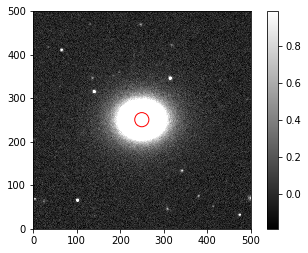

[[-0.00204625 -0.0152434   0.00602901 ... -0.06138668 -0.02918181
  -0.00203722]
 [ 0.0230068   0.03094443  0.08440225 ...  0.00908516 -0.12398312
  -0.04981663]
 [-0.03380163  0.02348149 -0.07467    ...  0.06846686 -0.01058937
   0.03981695]
 ...
 [-0.03296643 -0.0749846  -0.0010201  ... -0.06522775 -0.09926051
   0.00987371]
 [ 0.03411636  0.02240292  0.01211608 ...  0.05307335  0.06336311
   0.01422057]
 [-0.1012833  -0.05644951 -0.06936098 ...  0.05687811 -0.09302101
  -0.1031047 ]]


In [8]:
# Pix an example object
demo_object = target_data[target_data['agn'] == 1].iloc[0]
print('Example AGN:\n')
print(demo_object)

# Get image data
ra, dec = demo_object[['ra', 'dec']]
cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter='r', cutoutSideLength=500)

print('\n\nObject Image:\n')
plot_cutout_image(cutout_image, ra, dec)
print(cutout_image.image.array)

Example SN:

dec               -27.842176
agn                 0.000000
sn                  1.000000
ra                 53.527547
redshift            0.481349
galaxy_id           1.000000
host_ra            54.744612
host_dec          -30.690093
galaxy_redshift     0.009565
Name: 33, dtype: float64
500


Object Image:



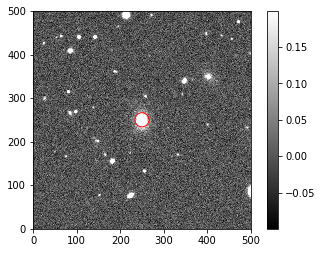

[[ 0.02690256 -0.00731727 -0.03777613 ...  0.0230803   0.01930741
  -0.01163381]
 [ 0.07327538  0.03444293  0.02303773 ... -0.0407268   0.00472885
  -0.00325076]
 [ 0.03121847 -0.04303588 -0.04181435 ...  0.0116944  -0.005575
  -0.00189974]
 ...
 [ 0.02226176  0.01433453 -0.01267893 ... -0.02581611 -0.01928379
  -0.01987473]
 [-0.04438048 -0.02051538 -0.00810805 ...  0.02800978 -0.00311919
   0.02548214]
 [ 0.02027069 -0.04720334 -0.02520684 ...  0.02025556 -0.01961409
  -0.04604525]]


In [9]:
# Pix an example object
demo_object = target_data[target_data['sn'] == 1].iloc[0]
print('Example SN:\n')
print(demo_object)

# Get image data
ra, dec = demo_object[['ra', 'dec']]
cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter='r', cutoutSideLength=500)

print('\n\nObject Image:\n')
plot_cutout_image(cutout_image, ra, dec)
print(cutout_image.image.array)

To Do:
1. Select image based on tract / patch
2. Select image for a given point along a lightcurve
